#  Car Pplate Detector 

> PART 4 / DETECT PLATES PRECENCE,COLOR,CORDINATES


<img src="/Users/adrian/Desktop/PY-PROJECTS/Machine_Learning/cart-plate-detector/fonts/img/img3.png" style="width:400px;height 400px"/>


     x [WxH] ---> MODEL ---> Y[presence,xs,ys,xe,ye,plates_color]

     xs -- x start
     xe -- x end

In [2]:
import os
from sys import  getsizeof
from random import randint
import csv

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image,ImageOps, ImageDraw,ImageFont

import numpy as np

import torch, torch.nn as nn, torch.optim as optim

# PREPARING DATA SETS

In [3]:
LABEL = '/m/01jfm_'
IMG_SIZE= (120,120)

csv_file  = open('OIDv4_ToolKit/OID/csv_folder/train-annotations-bbox.csv', 'r')
csv_reader= csv.reader(csv_file, delimiter=',')

box_count = 0

image_ids= []

data_x    = None
data_y    = None


# 'ImageID', 'Source', 'LabelName', 'Confidence', 'XMin', 'XMax', 'YMin', 'YMax', 'IsOccluded', 'IsTruncated', 'IsGroupOf', 'IsDepiction', 'IsInside'
for row in csv_reader:
    ImageID, Source, LabelName, Confidence, XMin, XMax, YMin, YMax, IsOccluded, IsTruncated, IsGroupOf, IsDepiction, IsInside = row
    if LabelName == LABEL:
        if IsGroupOf == '0' and IsOccluded == '0' and IsTruncated == '0':
            if 0.1 < abs(float(XMax) - float(XMin)) < 0.30 and 0.05 < abs(float(YMax) - float(YMin) < 0.25):

                img= Image.open(f'OIDv4_ToolKit/OID/Dataset/train/Vehicle registration plate/{ImageID}.jpg')
                img= ImageOps.grayscale(img)
                img = img.resize(IMG_SIZE)
                
                # plt.figure()
                # plt.imshow(img,cmap='gray')
                # if box_count> 10: 
                #     break


                x_matrix =  np.array(img,dtype=np.float32)
                x_matrix /= 255.0
                
                y_vector = np.array([
                    float(XMax),
                    float(XMin),
                    float(YMax),
                    float(YMin),
                    
                ])


                if box_count == 0:
                    data_x = np.array([x_matrix])
                    data_y = np.array([y_vector])
                else:
                    data_x = np.append(data_x,[x_matrix], axis= 0)
                    data_y = np.append(data_y,[y_vector], axis= 0)

                image_ids.append(ImageID)

                box_count += 1

print(f"processed {box_count} boxes")
print(f"X shape {data_x.shape}")
print(f"Y shape {data_y.shape}")




processed 1531 boxes
X shape (1531, 120, 120)
Y shape (1531, 4)


# <u>RUN ON  GPU </u>

In [22]:
  
# print("GPU available ?", torch.cuda.is_available())
# print("DEVICE", torch.cuda.current_device())

# device = torch.device("cuda:0")

# Built the model

In [4]:
modelBOX = nn.Sequential(
    nn.Conv2d( in_channels=1 , out_channels=32, kernel_size=(3,3)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(3,3)),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3)),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(3,3)),
    nn.Flatten(start_dim= 0),

    nn.Linear(in_features=9216, out_features=1024),
    nn.ReLU(),
    nn.Linear(in_features=1024, out_features=4),
    nn.Sigmoid()

)

In [5]:
x = torch. from_numpy(data_x[0]).type(torch.FloatTensor).view(1,*IMG_SIZE)
y = modelBOX(x)
print(y.shape)

torch.Size([4])


In [ ]:
# Transfer The model on GPU

# modelBOX.to(device)

# Training

In [ ]:
criterionBOX = nn.MSELoss()
optimizerBOX = optim.SGD(modelBOX.parameters(), lr= 0.001)

for epoch in range (1,5001):
    avg_loss = 0 
    for i in range(len(data_x)):
        x= torch.from_numpy(data_x[i]).type(torch.FloatTensor).view(1,*IMG_SIZE)#.to(device) # < -- for worck with GPU
        y= torch.from_numpy(data_y[i]).type(torch.FloatTensor) #.to(device) # < -- for worck with GPU
        
        optimizerBOX.zero_grad()
        yp = modelBOX(x)

        loss= criterionBOX(yp, y)

        loss.backward()
        optimizerBOX.step()

        avg_loss += loss.item()

    avg_loss /= len(data_x)    
    if epoch %100 == 0:
        print(f"epoch = {epoch:5} loss= {loss:15.8f}")
    if epoch % 1000 == 0:
        torch.save(modelBOX.state_dict(), f"models/{epoch}-box")


## USING TRAINED MODEL TO EXTRACT THE PLATE

[0.58657396 0.35492203 0.89400786 0.79636276]


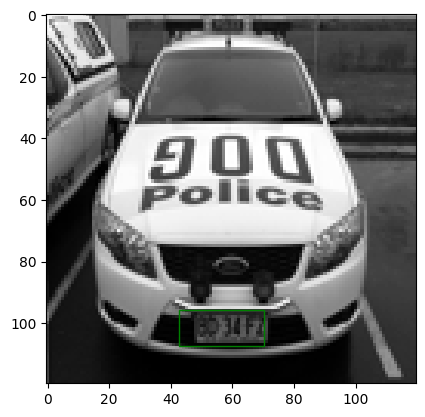

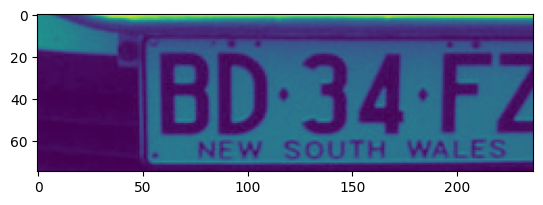

In [21]:
IMG_SIZE= (120,120)
CAM_SIZE= (1024,768)

data_set_file_names = ["ef353e3fc5c909ea","a2b4274133a6e372","77dac3900c6b1f35"]

rand_index= 2

img= Image.open(f"OIDv4_ToolKit/OID/Dataset/train/Vehicle registration plate/{data_set_file_names[rand_index]}.jpg")
img= ImageOps.grayscale(img)
img_small= img.resize(IMG_SIZE)

x_matrix= np.array(img_small,dtype=np.float32)
x_matrix /= 255.0

# plt.figure()


fig, ax= plt.subplots()

ax.imshow(x_matrix, cmap= 'gray')
#
x= torch.from_numpy(x_matrix).type(torch.FloatTensor).view(1,*IMG_SIZE)#.to(device)# in case use GPU
#
y= modelBOX(x)

yp= y.detach().numpy()#.cpu()
rect=patches.Rectangle(
    (yp[0] * IMG_SIZE[0],yp[2] * IMG_SIZE[1]),
    (yp[1] - yp[0]) * IMG_SIZE[0],
    (yp[3] - yp[2]) * IMG_SIZE[1],
    linewidth= 1,
    edgecolor= "g",
    facecolor= "none",    
)
ax.add_patch(rect)

print(yp)

x_matrix_original= np.array(img,dtype= np.float32)
x_matrix_plate= x_matrix_original[ int(yp[3]*CAM_SIZE[1]) : int(yp[2]*CAM_SIZE[1]) , int(yp[1]*CAM_SIZE[0]) : int(yp[0]*CAM_SIZE[0])]

plt.figure()
plt.imshow(x_matrix_plate)

<hr>

# Testing with new pictures 

[0.835444   0.7251622  0.6254536  0.53183466]


<Figure size 640x480 with 0 Axes>

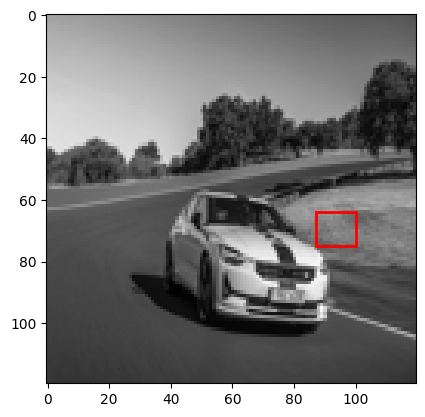

In [22]:
# rand_index = randint(0,data_x.shape[0]-1)
img= Image.open('/Users/adrian/Desktop/PY-PROJECTS/Machine_Learning/cart-plate-detector/test_img/polestar_2_bst_edition_270_1.jpeg')
img= ImageOps.grayscale(img)
img= img.resize(IMG_SIZE)
# img= ImageOps.invert(img)
x_matrix= np.array(img,dtype=np.float32)
x_matrix /= 255.0

# x_matrix= data_x[randint(0,800)]
plt.figure()

fig, ax= plt.subplots()

ax.imshow(x_matrix, cmap= 'gray')


x= torch.from_numpy(x_matrix).type(torch.FloatTensor).view(1,*IMG_SIZE)#.to(device)# in case use GPU
#
y= modelBOX(x)

yp= y.detach().numpy()#y.cpu()
rect=patches.Rectangle(
    (yp[0] * IMG_SIZE[0],yp[2] * IMG_SIZE[1]),
    (yp[1] - yp[0]) * IMG_SIZE[0],
    (yp[3] - yp[2]) * IMG_SIZE[1],
    linewidth= 2,
    edgecolor= "red",
    facecolor= "none",    
)
ax.add_patch(rect)
print(yp)

<hr>

# Save the Model

In [ ]:
## Save the trained model <--https://pytorch.org/tutorials/beginner/saving_loading_models.html
torch.save(modelBOX.state_dict(),'models/cart-plate-detector-9216-3x3-1362boxes')

# load saved model

In [6]:

modelBOX.load_state_dict(torch.load('models/cart-plate-detector-9216-3x3-1362boxes'))
modelBOX.eval()

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=0, end_dim=-1)
  (7): Linear(in_features=9216, out_features=1024, bias=True)
  (8): ReLU()
  (9): Linear(in_features=1024, out_features=4, bias=True)
  (10): Sigmoid()
)